## Fast Independent Component Analysis (FastICA) Algorithm



The FastICA algorithm is a popular and efficient method for Independent Component Analysis (ICA), aimed at separating a multivariate signal into additive, independent non-Gaussian signals. This technique finds extensive applications in signal processing, including the analysis of EEG, EOG, and EMG signals. Below is a detailed description of the FastICA algorithm, including its mathematical foundation and geometric interpretation.

### Mathematical Formulation

FastICA seeks to maximize the non-Gaussianity of the components of a mixed signal, under the assumption that the source signals are statistically independent and non-Gaussian. The algorithm involves several key steps:

#### 1. Centering

First, the observed data \(X\) is centered:
$$X_{centered} = X - \mathbb{E}[X]$$
where \(\mathbb{E}[X]\) is the mean of \(X\). Centering ensures that the data has a mean of zero.

#### 2. Whitening

Whitening transforms the observed data so that its components are uncorrelated and their variances equal unity. This is achieved by computing the eigenvalue decomposition of the covariance matrix of \(X\):
$$Cov(X) = EDE^T$$
and then transforming \(X\) to \(X_{whitened}\) using:
$$X_{whitened} = ED^{-1/2}E^T X_{centered}$$
where \(D\) is the diagonal matrix of eigenvalues, and \(E\) is the matrix of eigenvectors.

#### 3. Maximizing Non-Gaussianity

FastICA iteratively maximizes the non-Gaussianity of the components, typically measured by negentropy. The update rule for the weight vector \(w\) in each iteration is given by:
$$w^+ = \mathbb{E}[Xg(w^TX)] - \mathbb{E}[g'(w^TX)]w$$
where \(g(\cdot)\) is a non-linear function, and \(g'(\cdot)\) is its derivative. Common choices for \(g(\cdot)\) include \(\tanh(x)\) or \(x^3\).

#### 4. Normalization

After each update, \(w\) is normalized:
$$w = \frac{w^+}{\|w^+\|}$$
to ensure that it remains a unit vector.

#### 5. Decorrelation

To ensure that the components remain independent, FastICA employs a symmetric decorrelation step, effectively orthogonalizing the weight vectors.

### Geometric Interpretation

Geometrically, FastICA can be interpreted as finding directions in the data space along which the projections of the data have maximal non-Gaussianity. The whitening step corresponds to transforming the data into a spherical shape, where the covariance matrix is the identity matrix. This transformation simplifies the problem, making it easier to find the independent components by rotating the axes in the whitened space to match the directions of the original, independent sources.

The update rule for \(w\) effectively rotates and scales the axes in the whitened space to align with the directions of maximum non-Gaussianity, thereby recovering the independent components. The normalization and decorrelation steps ensure that the components remain independent as the algorithm iterates.

### Conclusion

FastICA is a powerful method for separating independent components from multivariate data, leveraging the non-Gaussianity of the source signals. Its efficiency and simplicity make it suitable for a wide range of applications in signal processing and data analysis.


### Implementation

In [2]:
import numpy as np

def g(x):
    """Non-linear function used to approximate negentropy."""
    return np.tanh(x)

def g_prime(x):
    """Derivative of the g function."""
    return 1 - np.tanh(x) ** 2

def center(X):
    """Center the data (variables)."""
    X_mean = X.mean(axis=0, keepdims=True)
    return X - X_mean

def whiten(X):
    """Whiten the data using its covariance matrix."""
    cov = np.cov(X, rowvar=False)
    d, E = np.linalg.eigh(cov)
    D_inv = np.diag(1. / np.sqrt(d))
    X_whitened = X.dot(E).dot(D_inv).dot(E.T)
    return X_whitened

def fastica(X, iterations=1000, tolerance=1e-5):
    """Simple FastICA implementation."""
    # Center and whiten data
    X = center(X)
    X = whiten(X)
    
    n_components = X.shape[1]
    W = np.random.rand(n_components, n_components)
    
    for _ in range(iterations):
        W_old = W.copy()
        for i in range(n_components):
            w = W[i, :].copy()
            xw = np.dot(X, w)
            gw = g(xw)
            g_prime_w = g_prime(xw)
            w = np.dot(X.T, gw) - g_prime_w.mean() * w
            W[i, :] = w / np.linalg.norm(w)
        
        # Decorrelate weights
        W = np.linalg.qr(W)[0]
        
        # Check for convergence
        lim = np.max(np.abs(np.abs(np.diag(np.dot(W, W_old.T))) - 1))
        if lim < tolerance:
            break
    
    S = np.dot(W, X.T).T
    return S


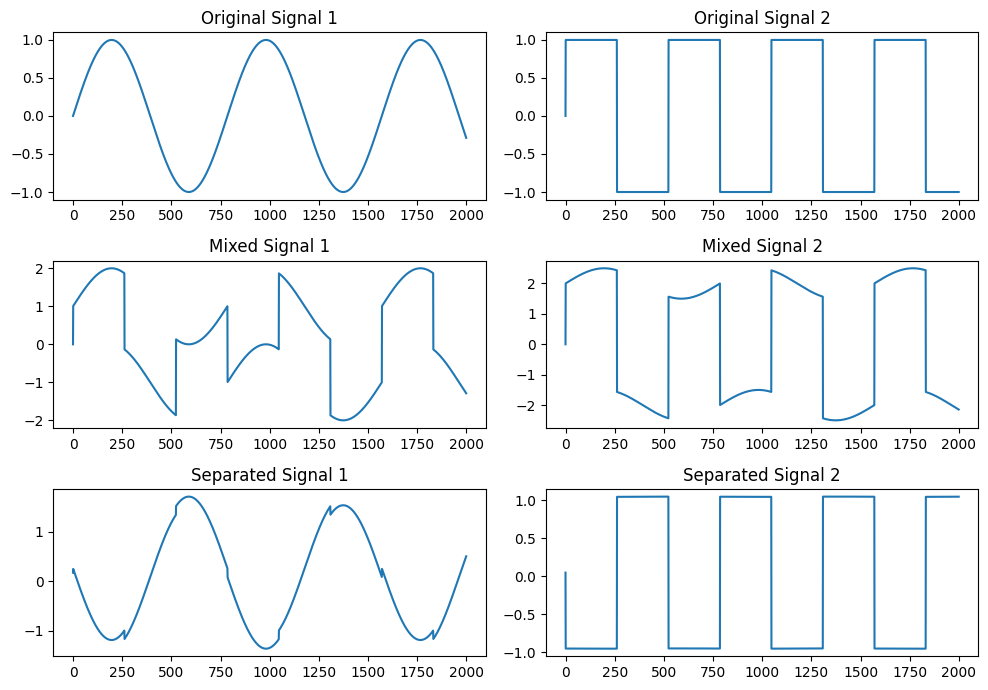

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

# Generate sample data
np.random.seed(0)
n_samples = 2000
time = np.linspace(0, 8, n_samples)

# Original signals
s1 = np.sin(2 * time)  # Sinusoidal signal
s2 = np.sign(np.sin(3 * time))  # Square signal

# Stack the signals to create a 2D array
S = np.c_[s1, s2]

# Mixing matrix
A = np.array([[1, 1], [0.5, 2]])

# Mixed signals
X = S.dot(A.T)

# Perform ICA

S_ = fastica(X)
# Get estimated mixing matrix
A_ = np.linalg.pinv(S_).dot(X)

# Plotting
fig, axs = plt.subplots(3, 2, figsize=(10, 7))

# Plot original signals
axs[0, 0].plot(S[:, 0])
axs[0, 1].plot(S[:, 1])

axs[0, 0].set_title('Original Signal 1')
axs[0, 1].set_title('Original Signal 2')

axs[1, 0].plot(X[:, 0])
axs[1, 1].plot(X[:, 1])
axs[1, 0].set_title('Mixed Signal 1')
axs[1, 1].set_title('Mixed Signal 2')

axs[2, 1].plot(S_[:, 0])
axs[2, 0].plot(S_[:, 1])
axs[2, 0].set_title('Separated Signal 1')
axs[2, 1].set_title('Separated Signal 2')

plt.tight_layout()
plt.show()



### Limitations of FastICA

While FastICA is a powerful algorithm for Independent Component Analysis, known for its efficiency and ease of use, there are several limitations specific to its implementation and operational characteristics.

#### Sensitivity to Initial Conditions

- **Description**: FastICA's convergence to a solution can be significantly influenced by its initial starting point. The algorithm iteratively updates the unmixing matrix from an initial guess towards maximizing non-Gaussianity.
- **Impact**: Poor initialization can lead to slow convergence or convergence to local optima that do not represent the best separation of source signals.

#### Fixed Number of Components

- **Description**: FastICA requires the specification of the number of independent components to be extracted.
- **Impact**: Determining the correct number of components a priori can be challenging. An incorrect number of components can lead to overfitting (extracting too many components) or underfitting (missing significant components), which affects the quality of the separation and the interpretability of the results.

#### Performance in High-Dimensional Data

- **Description**: While FastICA is designed to be efficient, its performance can degrade with very high-dimensional data or a large number of observations.
- **Impact**: The computational cost and memory requirements increase with data dimensionality, which can limit FastICA's applicability to very large datasets or necessitate dimensionality reduction preprocessing steps.

Note: the non-Gaussianity and independence assumptions are foundational limitation to all ICA algorithms.
